# 2. Transfer learnt model from a model trained on EfficientNet by unfreezing some existing layers

| Task                   | Sub-task                                | Comments                                  |
|------------------------|-----------------------------------------|-------------------------------------------|
| Data Preprocessing     | Scaling and Resizing                    | Done                                      |
|                        | Image Augmentation                      | Done                                      |
|                        | Train and test data handled correctly   | Done                                      |
|                        | Gaussian Blur, Histogram Equalization, and Intensity thresholds | Done |
| Model Trained          | Training Time?                         |     20 epochs in 2634 seconds using GPU P100                                 |
|                        | AUC and Confusion Matrix Computed      | Done                                      |
|  |Overfitting/Underfitting checked and handled| Done
| Empirical Tuning       | Interpretability Implemented           | Done                                      |
|                        | 3 Rounds of Tuning |  Done |


In [1]:
# warnings removal
import warnings
warnings.filterwarnings('ignore')

In [2]:
# basic libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

2024-04-05 21:26:25.551622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 21:26:25.551739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 21:26:25.697997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# model evaluation libraries
from sklearn.metrics import confusion_matrix, auc, roc_curve
from itertools import cycle

In [5]:
# model interpretability libraries
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [6]:
# constants
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 6
NUM_UNFREEZED = 20

## 2.1. Data Preprocessing

In [7]:
# preprocessing image
def preprocess_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Gaussian blur
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    # Intensity thresholding
    _, thresholded_img = cv2.threshold(blurred_img, 150, 255, cv2.THRESH_BINARY)
    return cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2BGR)

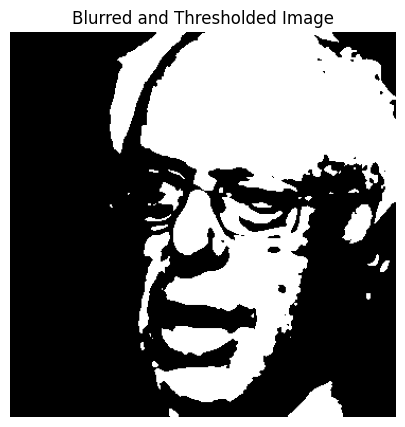

In [8]:
# load the original image
original_image = cv2.imread("/kaggle/input/face-expressions/dataset/Angry/00a7cb9cf18d3a015a9e932952f942fd4bcad8044bcef5e0c05de51d~angry.jpg")  # Replace with the path to your image
final_image = preprocess_image(original_image)

# display the final image
plt.figure(figsize=(10, 5))
plt.imshow(final_image)
plt.title('Blurred and Thresholded Image')
plt.axis('off')
plt.show()

In [9]:
# image augmentation and train-test split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=preprocess_image
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/face-expressions/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/face-expressions/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12365 images belonging to 6 classes.
Found 3088 images belonging to 6 classes.


## 2.2. Model Building

In [15]:
# creating base model using EfficientNetB0
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)

In [16]:
# freeze all layers
base_model.trainable = False

In [17]:
# unfreeze some layers
for layer in base_model.layers[-NUM_UNFREEZED:]:
    layer.trainable = True

In [18]:
# adding additional classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [19]:
# creating final model
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# model training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE
)

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 324s 730ms/step - accuracy: 0.2548 - loss: 1.7118 - val_accuracy: 0.2539 - val_loss: 1.6523
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2500 - loss: 1.6280 - val_accuracy: 0.3750 - val_loss: 1.6501
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 261s 666ms/step - accuracy: 0.2527 - loss: 1.6775 - val_accuracy: 0.2607 - val_loss: 1.6579
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.1562 - loss: 1.6197 - val_accuracy: 0.2500 - val_loss: 1.7267
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 255s 650ms/step - accuracy: 0.2575 - loss: 1.6675 - val_accuracy: 0.2598 - val_loss: 1.6537
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.2812 - loss: 1.5447 - val_accuracy: 0.4375 - val_loss: 1.5858
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 253s 647ms/step - accuracy: 0.2651 - loss: 1.6683 - val_accuracy: 0.2611 - val_loss: 1.6561
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.1875 - loss: 1.

In [22]:
# check model losses and accuracies
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Train Loss: {train_loss}, Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}, Accuracy: {test_accuracy}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 208s 538ms/step - accuracy: 0.2585 - loss: 1.6510
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 512ms/step - accuracy: 0.2448 - loss: 1.6578
Train Loss: 1.6527856588363647, Accuracy: 0.2545895576477051
Test Loss: 1.652293086051941, Accuracy: 0.25453367829322815


# 2.3. Model Tuning

In [11]:
# function to perform tuning
def model_tuning(hidden_layer_nodes=128, num_unfreezed=NUM_UNFREEZED, batch_size=BATCH_SIZE, epochs=EPOCHS):
    # creating base model using EfficientNetB0
    base_model = EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)
    # freeze all layers
    base_model.trainable = False
    # unfreeze some layers
    for layer in base_model.layers[-num_unfreezed:]:
        layer.trainable = True
    # adding additional classification layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(hidden_layer_nodes, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    # creating final model
    model = Model(inputs=base_model.input, outputs=predictions)
    # model compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # model training
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=train_generator.n // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // batch_size
    )
    return model

In [30]:
# 1st round of tuning
model1 = model_tuning(hidden_layer_nodes=512)

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 299s 674ms/step - accuracy: 0.2528 - loss: 1.7233 - val_accuracy: 0.2604 - val_loss: 1.6586
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2812 - loss: 1.6874 - val_accuracy: 0.3125 - val_loss: 1.6164
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 234s 598ms/step - accuracy: 0.2535 - loss: 1.6727 - val_accuracy: 0.2604 - val_loss: 1.6623
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.3125 - loss: 1.6797 - val_accuracy: 0.3125 - val_loss: 1.6788
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 235s 602ms/step - accuracy: 0.2448 - loss: 1.6728 - val_accuracy: 0.2536 - val_loss: 1.6641
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.2812 - loss: 1.6814 - val_accuracy: 0.3125 - val_loss: 1.4666
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 235s 601ms/step - accuracy: 0.2425 - loss: 1.6612 - val_accuracy: 0.2419 - val_loss: 1.6548
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.2188 - loss: 1.

***Increasing hidden layer nodes didn't bring accuracy in model.***

In [31]:
# check model losses and accuracies
train_loss1, train_accuracy1 = model1.evaluate(train_generator)
test_loss1, test_accuracy1 = model1.evaluate(validation_generator)
print(f"Train Loss: {train_loss1}, Accuracy: {train_accuracy1}")
print(f"Test Loss: {test_loss1}, Accuracy: {test_accuracy1}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 204s 527ms/step - accuracy: 0.2530 - loss: 1.6561
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.2432 - loss: 1.6554
Train Loss: 1.653752088546753, Accuracy: 0.26057419180870056
Test Loss: 1.6534110307693481, Accuracy: 0.2606865167617798


In [50]:
# 2nd round of tuning
model2 = model_tuning(num_unfreezed=100)

Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 310s 675ms/step - accuracy: 0.2391 - loss: 1.7393 - val_accuracy: 0.2604 - val_loss: 1.6537
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4375 - loss: 1.5233 - val_accuracy: 0.2500 - val_loss: 1.8302
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 229s 585ms/step - accuracy: 0.2550 - loss: 1.6710 - val_accuracy: 0.2552 - val_loss: 1.6550
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.3750 - loss: 1.5353 - val_accuracy: 0.1250 - val_loss: 1.8309
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 225s 576ms/step - accuracy: 0.2695 - loss: 1.6650 - val_accuracy: 0.2119 - val_loss: 1.6557
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.2188 - loss: 1.7585 - val_accuracy: 0.2500 - val_loss: 1.5995
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 224s 573ms/step - accuracy: 0.2625 - loss: 1.6516 - val_accuracy: 0.2428 - val_loss: 1.6589
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - accuracy: 0.2812 - loss: 1.5

In [51]:
# check model losses and accuracies
train_loss2, train_accuracy2 = model2.evaluate(train_generator)
test_loss2, test_accuracy2 = model2.evaluate(validation_generator)
print(f"Train Loss: {train_loss2}, Accuracy: {train_accuracy2}")
print(f"Test Loss: {test_loss2}, Accuracy: {test_accuracy2}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 200s 516ms/step - accuracy: 0.2375 - loss: 1.6645
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 500ms/step - accuracy: 0.2685 - loss: 1.6565
Train Loss: 1.664440393447876, Accuracy: 0.24197331070899963
Test Loss: 1.66304349899292, Accuracy: 0.24222798645496368


***Increasing number of unfreezed layers upto 100 didn't raise any accuracy.***

In [12]:
# 3rd round of tuning
model3 = model_tuning(batch_size=64)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
  1/193 ━━━━━━━━━━━━━━━━━━━━ 2:44:07 51s/step - accuracy: 0.2500 - loss: 1.8293

I0000 00:00:1712352495.956061     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/193 ━━━━━━━━━━━━━━━━━━━━ 234s 950ms/step - accuracy: 0.2672 - loss: 1.7435 - val_accuracy: 0.2038 - val_loss: 1.6680
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 174s 907ms/step - accuracy: 0.2616 - loss: 1.6761 - val_accuracy: 0.2773 - val_loss: 1.6487
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.3125 - loss: 1.6046 - val_accuracy: 0.3125 - val_loss: 1.8120
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 145s 729ms/step - accuracy: 0.2737 - loss: 1.6722 - val_accuracy: 0.2572 - val_loss: 1.6544
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 129s 670ms/step - accuracy: 0.2465 - loss: 1.6693 - val_accuracy: 0.2624 - val_loss: 1.6583
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 1.6926 - val_accuracy: 0.2500 - val_loss: 1.6626
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 134s 676ms/step - accuracy: 0.2577 - loss: 1.6609 - val_accuracy: 0.2546 - val_loss: 1.6627
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 122s 635ms/step - accuracy: 0.2582 - loss: 1.6604 - va

In [13]:
# check model losses and accuracies
train_loss3, train_accuracy3 = model3.evaluate(train_generator)
test_loss3, test_accuracy3 = model3.evaluate(validation_generator)
print(f"Train Loss: {train_loss3}, Accuracy: {train_accuracy3}")
print(f"Test Loss: {test_loss3}, Accuracy: {test_accuracy3}")

387/387 ━━━━━━━━━━━━━━━━━━━━ 210s 543ms/step - accuracy: 0.2464 - loss: 1.6563
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 506ms/step - accuracy: 0.2539 - loss: 1.6589
Train Loss: 1.6529589891433716, Accuracy: 0.2545895576477051
Test Loss: 1.6530077457427979, Accuracy: 0.25453367829322815


In [23]:
# select final model
final_model = model

***Since there is not much difference in accuracy seen, original model was considered final one and it is concluded that using transfer learning by unfreezing few layers from EfficientNet isn't appropriate in comparison of EfficientNet with all layers.***

## 2.4. Model Evaluation

In [24]:
# final model test loss and accuracy
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")

Loss: 1.652293086051941, Accuracy: 0.25453367829322815


In [25]:
# make predictions on the validation generator
y_true = validation_generator.classes
y_pred = np.argmax(final_model.predict(validation_generator), axis=-1)

97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 577ms/step


In [26]:
# confusion matrix generation
conf_matrix = confusion_matrix(y_true, y_pred)

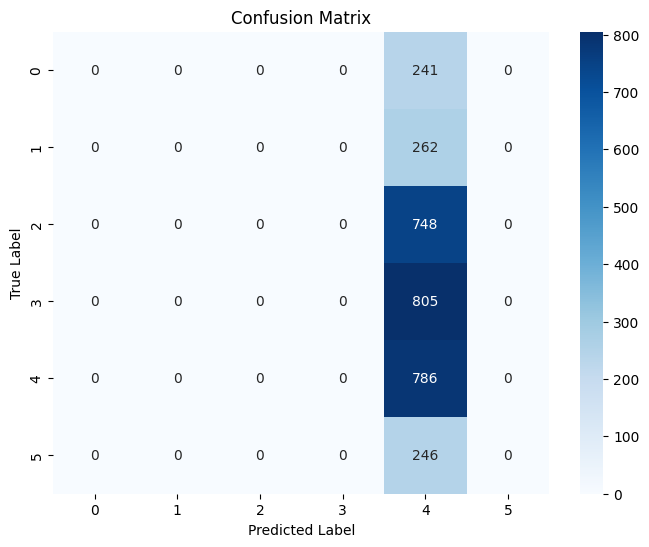

In [27]:
# confusion matrix plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# ROC curve generation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    y_true_binary = (y_true == i)
    y_pred_binary = (y_pred == i)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])

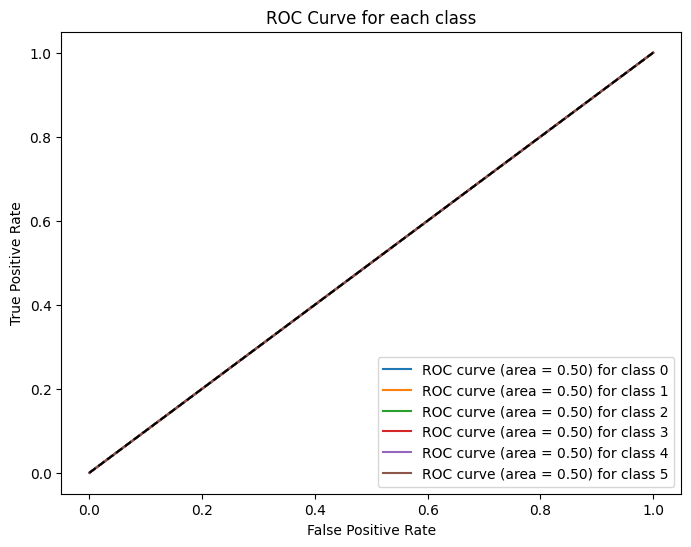

In [29]:
# ROC curve plotting
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()

In [30]:
# create LIME explainer
explainer = lime_image.LimeImageExplainer()

In [31]:
# use sample index
sample_idx = np.random.choice(len(validation_generator))
sample_image, _ = validation_generator[sample_idx]
sample_image = sample_image[0]
true_label = np.argmax(validation_generator.classes[sample_idx])

In [32]:
# create explanation using instance
explanation = explainer.explain_instance(sample_image, final_model.predict, top_labels=NUM_CLASSES, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Face Expression: Sad


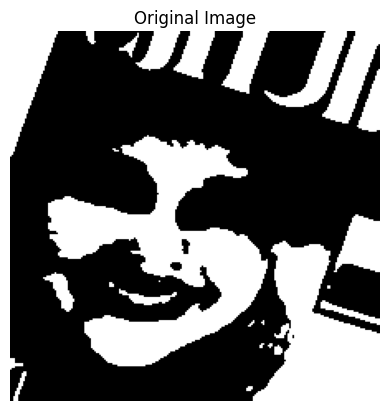

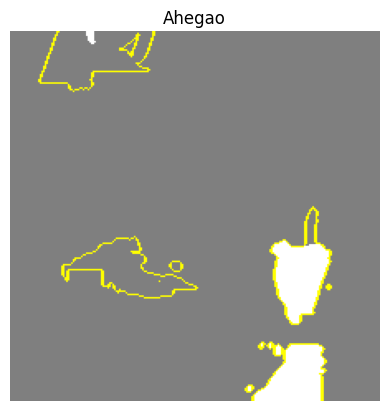

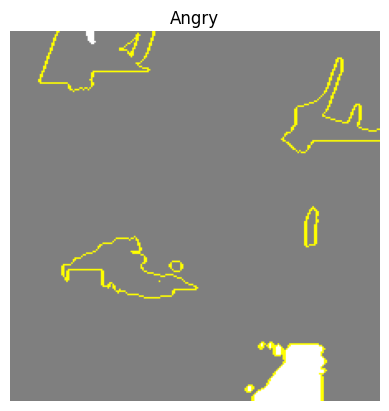

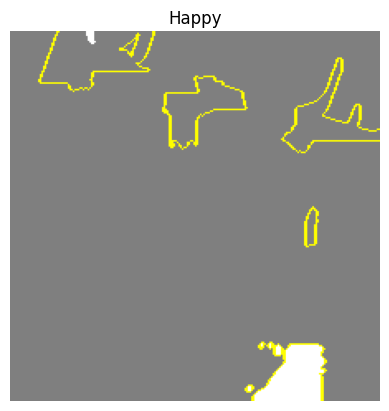

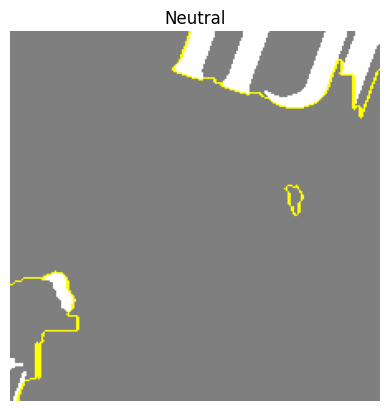

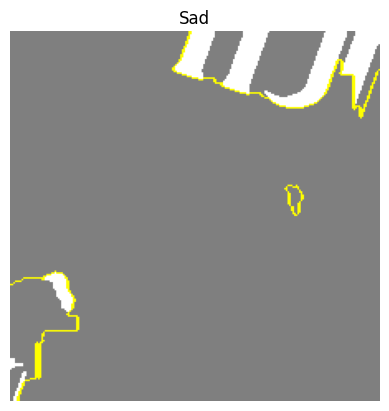

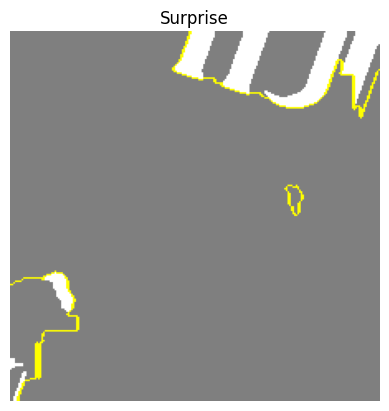

In [33]:
# perform prediction using the model
class_probabilities = model.predict(sample_image.reshape(1, 224, 224, 3))
predicted_class_index = np.argmax(class_probabilities)
predicted_class_name = list(validation_generator.class_indices.keys())[predicted_class_index]
print(f"Face Expression: {predicted_class_name}")

plt.imshow(sample_image)
plt.axis('off')
plt.title('Original Image')
plt.show()

# show LIME explanation
for label_idx in range(6):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[label_idx], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.title(f'{list(validation_generator.class_indices.keys())[label_idx]}')
    plt.show()

In [34]:
# saving model
model.save('enu_model.h5')